<a href="https://colab.research.google.com/github/jorgeerrz/mistaken_mice/blob/master/Filter_the_trials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [123]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[10]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'lfp', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'waveform_w', 'waveform_u', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'lfp_passive', 'pupil_passive', 'wheel_passive'])


In [130]:
#@title Session number 10
print("Number of sessions = ", np.size(alldat), ", session 10 has ", dat['response'].shape[0]," trials")

Number of sessions =  39 , session 10 has  342  trials


In [112]:
def filter_trials(session_data):
  '''Function that filters trials from session that comply 
  with contrast_left == contrast_right > 0 and choice != 0

  Input: the data structure from one session 
  Output: an array of spikes, an array of RTs and an array of choices
  '''
  #Initialize void output lists
  spikes_trials = []
  RTs_trials = []
  choices_trials = []
  # Loop over trials in session
  for i in range(len(session_data['response_time'])):
    #Only choose trials for which conditions apply
    if session_data['contrast_left'][i] == session_data['contrast_right'][i] and session_data['contrast_left'][i] > 0 and session_data['response'][i] != 0:
      #Spikes are stored in session_data as neurons x trials x timebin, we care about second dimension
      spikes_trials.append(session_data['spks'][:,i,:])
      RTs_trials.append(session_data['response_time'][i])
      choices_trials.append(session_data['response'][i])               

  spikes_trials = np.asarray(spikes_trials)
  RTs_trials = np.asarray(RTs_trials)
  choices_trials = np.asarray(choices_trials)

  return spikes_trials, RTs_trials, choices_trials


In [131]:
sp, rt, ch = filter_trials(dat)

In [134]:
sp.shape, rt.shape, ch.shape
print("we have", ch.shape[0], "trials to use")

we have 24 trials to use


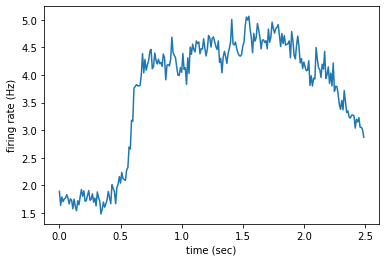

In [135]:
#@title basic plots of population average on selected unfair trials
from matplotlib import pyplot as plt
dt = dat['bin_size'] # binning at 10 ms
NT = sp.shape[-1]

ax = plt.gca()

plt.plot(dt * np.arange(NT), 1/dt * sp.mean(axis=(0,1))) # average across trials and neurons

#plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');